## Imports

In [8]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle
import random



import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

tf.config.threading.set_inter_op_parallelism_threads(
    16
)
tf.config.threading.set_intra_op_parallelism_threads(
    16
)

from DS_2_2024_HW2_efficient_net import EfficientNet
import matplotlib.pyplot as plt
from collections import Counter

In [9]:
tf.keras.utils.set_random_seed(16)

## Data Exploration and augmentation

In [10]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

In [11]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord").prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord").prefetch(tf.data.AUTOTUNE)

# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

In [12]:
counter = Counter()
for element in train:
    label = element['label'].numpy()  # Convert tensor to numpy
    counter[label] += 1
print(counter)

# Tedy vsechny labels maji 63 obrazku v trainu (9 v devu), labelu je 34 vcetne nuly, 2142 a 306 obrazku v trainu a devu

Counter({23: 63, 3: 63, 33: 63, 22: 63, 25: 63, 1: 63, 10: 63, 14: 63, 21: 63, 16: 63, 28: 63, 13: 63, 11: 63, 24: 63, 17: 63, 19: 63, 12: 63, 31: 63, 30: 63, 8: 63, 15: 63, 7: 63, 18: 63, 32: 63, 5: 63, 0: 63, 4: 63, 2: 63, 20: 63, 26: 63, 6: 63, 9: 63, 27: 63, 29: 63})


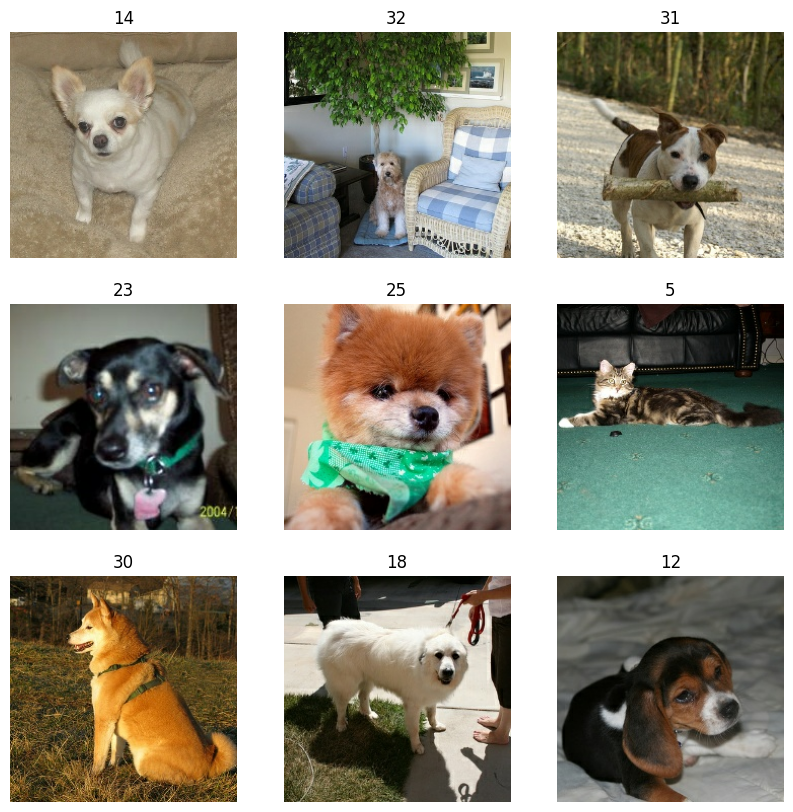

In [13]:
plt.figure(figsize=(10, 10))
for i, images in enumerate(train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images['image'].numpy())
    plt.title(int(images['label']))
    plt.axis('off')
    plt.plot()

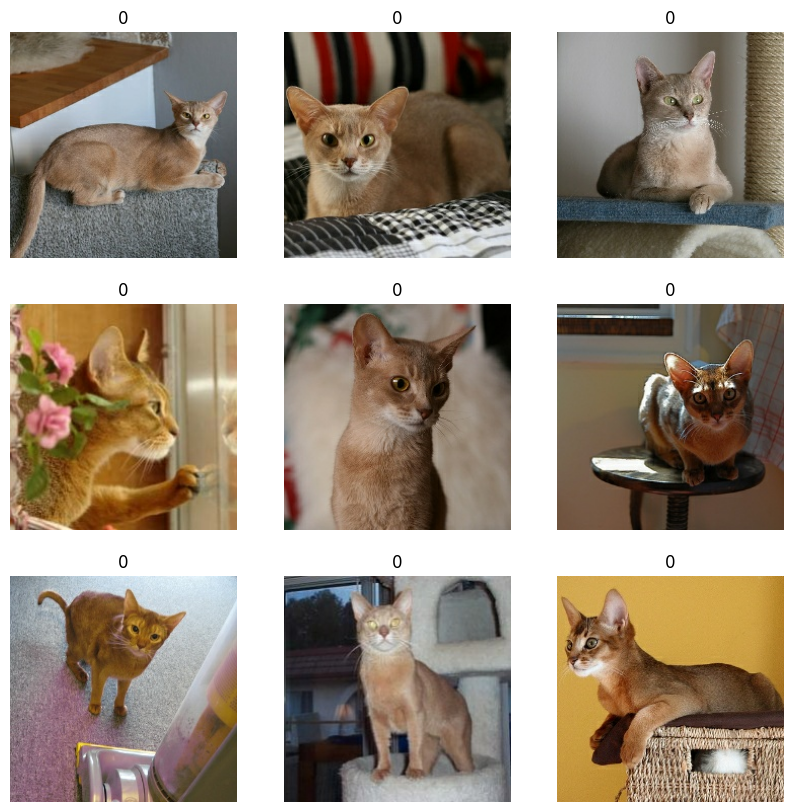

In [14]:
filtered_label0 = train.filter(lambda x: x['label'] == 0)

plt.figure(figsize=(10, 10))
for i, images in enumerate(filtered_label0.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images['image'].numpy())
    plt.title(int(images['label']))
    plt.axis('off')
    plt.plot()

In [15]:
#Augment the dataset 
def augment_train(input):
    image = input['image']
    label = input['label']

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_crop(image, [H, W, C])
    image = tf.image.random_flip_up_down(image) #we thought this one does not make much sense for our dataset but the results were better so we keep it
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_crop(image, [H,W,C])
    return image, label

train = train.map(augment_train, num_parallel_calls=16)
dev = dev.map(augment_dev, num_parallel_calls=16)




In [16]:
num_images = 0
for image, label in train:
    num_images += tf.shape(image)[0]  # Add the number of images in the current batch

print(f"Number of images in training set: {num_images.numpy()}")
num_training_examples=num_images.numpy()

Number of images in training set: 479808


In [17]:
# Apply .batch() to 'train' and 'dev' with some choice of batch size 
batch_size = 128
train = train.batch(batch_size)
dev = dev.batch(batch_size)

In [18]:
train_shape = next(iter(train))[0].shape
dev_shape = next(iter(dev))[0].shape

print("Shape of training data:", train_shape)
print("Shape of validation data:", dev_shape)

Shape of training data: (128, 224, 224, 3)
Shape of validation data: (128, 224, 224, 3)


# Build Model

Continue by initializing EfficientNet, building the model, augmentation and training.

In [19]:
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition

base_model = EfficientNet(
    weights='efficientnet.h5',
    include_top = False,
    dropout_rate= 0.1, #skusali sme 0.15, 0.2. Najlepsie vyslo 0.1
    default_resolution=224,
    width_coefficient=1.0,
    depth_coefficient=1.0
)



In [22]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters

#Fine-tuning: If you’re using EfficientNet as a pre-trained model and want to fine-tune it on a specific task, 
#it’s common to freeze the early layers and only train the later layers. The rationale is that the early layers of
#a Convolutional Neural Network (CNN) usually learn general features (like edges and textures), while the later layers
#learn more task-specific features.

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):  
        layer.trainable = False 
#Freeznut prave tieto vrstvy nam bolo poradene od jedneho informatika. Vzhladom na porovnatelnu accuracy ostatnych timov sa zda ze to nebolo klucove,
#a pravdepodobne by stacilo vziat nejaky pevny pocet poslednych vrstiev ako pisete v poznamkach vyssie.
#Dokopy nam z efficient netu ostalo 200000 trenovatelnych parametrov.
base_model.summary()

Model: "efficientnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                      

In [23]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through Efficient model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

inputs = tf.keras.layers.Input([H, W, C])
hidden = base_model(inputs)[0]

# pridame niekolko vlastnych fully-connected vrstiev spolu s residual connection
hidden = tf.keras.layers.Dropout(0.2)(hidden)
dense_output = tf.keras.layers.Dense(128, activation='relu')(hidden)
hidden = tf.keras.layers.BatchNormalization()(dense_output)
hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
hidden = tf.keras.layers.Add()([dense_output, hidden])
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)
outputs = tf.keras.layers.Dense(LABELS, activation=tf.keras.activations.softmax)(hidden)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet (Functional)      [(None, 1280),       4049564     ['input_2[0][0]']                
                                 (None, 7, 7, 1280)                                               
                                , (None, 14, 14, 11                                               
                                2),                                                               
                                 (None, 28, 28, 40)                                           

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)

#early stopping proti overfitovaniu 

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)

epochs = 30
#skusali sme rozne velkosti batchov a rozny pocet epoch.

model.fit(train,
          epochs=epochs,
          validation_data=dev,
          callbacks=[early_call])

Epoch 1/30
17/17 [==============================] - 194s 11s/step - loss: 3.6420 - sparse_categorical_accuracy: 0.0808 - val_loss: 3.3514 - val_sparse_categorical_accuracy: 0.0752
Epoch 2/30
17/17 [==============================] - 181s 11s/step - loss: 2.5312 - sparse_categorical_accuracy: 0.3310 - val_loss: 3.0959 - val_sparse_categorical_accuracy: 0.2222
Epoch 3/30
17/17 [==============================] - 178s 10s/step - loss: 1.9448 - sparse_categorical_accuracy: 0.4958 - val_loss: 2.7742 - val_sparse_categorical_accuracy: 0.3366
Epoch 4/30
17/17 [==============================] - 169s 10s/step - loss: 1.5529 - sparse_categorical_accuracy: 0.6167 - val_loss: 2.5003 - val_sparse_categorical_accuracy: 0.4150
Epoch 5/30
17/17 [==============================] - 167s 10s/step - loss: 1.2191 - sparse_categorical_accuracy: 0.7012 - val_loss: 2.1087 - val_sparse_categorical_accuracy: 0.5425
Epoch 6/30
17/17 [==============================] - 169s 10s/step - loss: 1.0066 - sparse_categorica

# Evaluate

Load test dataset, predict labels and store results. Note that (for educational purposes) we load the data from pickled list. Therefore, transformation to Tensorflow dataset has to be done.

In [26]:
# Load test dataset stored as pickled list.
ids = list(range(0, 150))

with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)
test = test.batch(batch_size) #batching

# Predictions
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

results=pd.DataFrame({'ID': ids,'TARGET': test_prediction})

results.to_csv('hw2_prediction4.csv', index= False ,header=True)